In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import probplot
import datetime
import matplotlib.colors
from sklearn.preprocessing import LabelEncoder
import pickle

In [2]:
df = pd.read_csv('car_prices.csv')
df.info()
print("-------------------------------")
print("\nPercentage of Missing Values: ")
df.isnull().sum()/df.count()*100

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 558837 entries, 0 to 558836
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          558837 non-null  int64  
 1   make          548536 non-null  object 
 2   model         548438 non-null  object 
 3   trim          548186 non-null  object 
 4   body          545642 non-null  object 
 5   transmission  493485 non-null  object 
 6   vin           558833 non-null  object 
 7   state         558837 non-null  object 
 8   condition     547017 non-null  float64
 9   odometer      558743 non-null  float64
 10  color         558088 non-null  object 
 11  interior      558088 non-null  object 
 12  seller        558837 non-null  object 
 13  mmr           558799 non-null  float64
 14  sellingprice  558825 non-null  float64
 15  saledate      558825 non-null  object 
dtypes: float64(4), int64(1), object(11)
memory usage: 68.2+ MB
-------------------------------



year             0.000000
make             1.877908
model            1.896112
trim             1.942954
body             2.418252
transmission    13.242956
vin              0.000716
state            0.000000
condition        2.160810
odometer         0.016823
color            0.134208
interior         0.134208
seller           0.000000
mmr              0.006800
sellingprice     0.002147
saledate         0.002147
dtype: float64

#### Mising Values
There are few missing values in the data, the biggest one is transmission column (13%). 
I will fill the missing transmission values with 'Automatic' since it is the most common transmission in the US and becuase people today will specify if the car is manual.
Using df.unique(), I look for the unique values of each column in the data and fill nan values in the rest of the data as 'other', removing them completly only where I can not replace it with inforaming values.

In [3]:
df['transmission'] = df['transmission'].fillna('automatic')
df['make'] = df['make'].fillna('other')
df['model'] = df['model'].fillna('other')
df['trim'] = df['trim'].fillna('other')
df['color'] = df['color'].fillna('other')
df['body'] = df['body'].fillna('other')
df['color'] = df['color'].replace('—', 'other')
df['interior'] = df['interior'].replace('—', 'other')
df.dropna(subset=['vin'], inplace=True)
df.dropna(subset=['saledate'], inplace=True)
df.dropna(subset=['interior'], inplace=True)
df.dropna(subset=['odometer'], inplace=True)
df.dropna(subset=['condition'], inplace=True)
df.dropna(subset=['mmr'], inplace=True)
print(df.isnull().sum())

year            0
make            0
model           0
trim            0
body            0
transmission    0
vin             0
state           0
condition       0
odometer        0
color           0
interior        0
seller          0
mmr             0
sellingprice    0
saledate        0
dtype: int64


#### Distribution of Numerical Values
Histogram allows me to see the peaks and shapes of the numerical data, it will give me insights into where the most values are, and the general distribution of the columns.
Notice the logarithmic scale on y-axis.

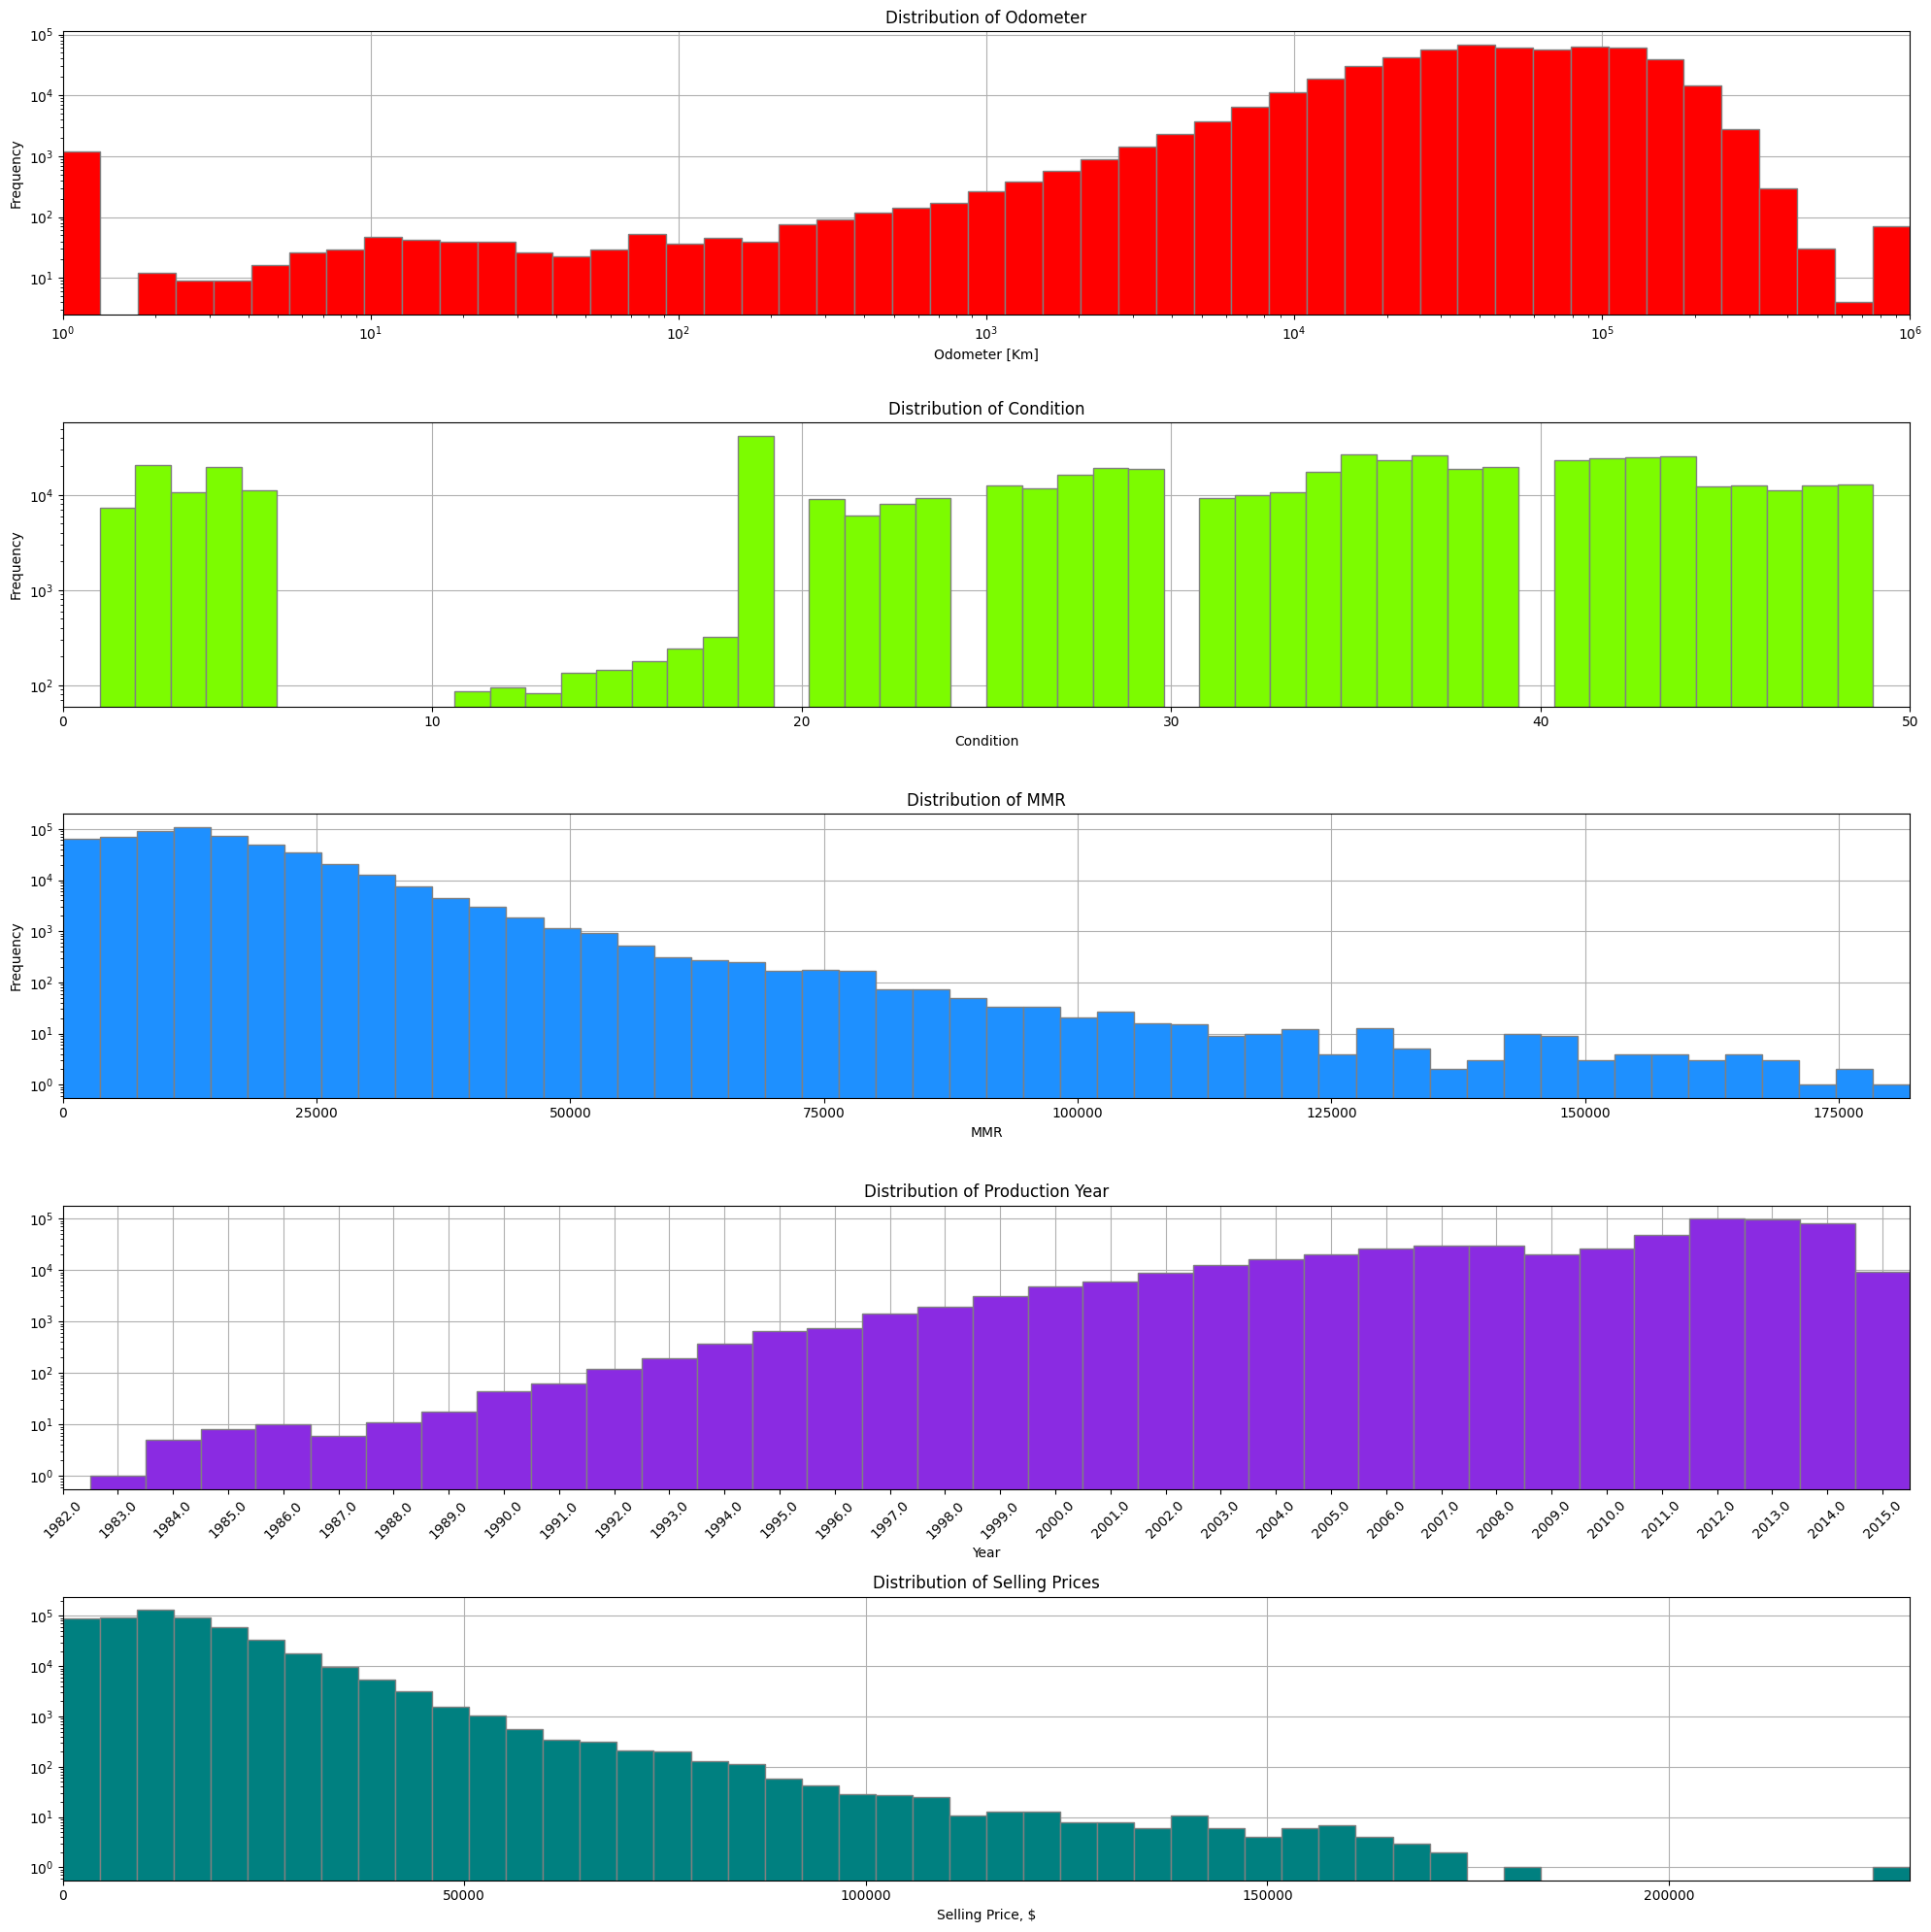

In [4]:
bins_num = 50
bins_odo = np.logspace(np.log10(np.amin(df['odometer'])), np.log10(np.amax(df['odometer'])), bins_num)
bins_year = np.linspace(int(np.amin(df['year'])), int(np.amax(df['year'])), df['year'].nunique())
fig, axs = plt.subplots(5, 1, figsize=(20, 20), tight_layout=True)

axs[0].hist(df['odometer'].dropna(), bins=bins_odo, facecolor='red', edgecolor='gray', log=True)
axs[0].set_xlabel('Odometer [Km]', fontsize='medium')
axs[0].set_xscale('log')
axs[0].set_xlim(1, np.amax(df['odometer'])+10)
axs[0].set_ylabel('Frequency')
axs[0].set_title('Distribution of Odometer')
axs[0].grid(True)
axs[0].set_axisbelow(True)

axs[1].hist(df['condition'].dropna(), bins=bins_num, facecolor='lawngreen', edgecolor='gray', log=True)
axs[1].set_xlabel('Condition', fontsize='medium')
axs[1].set_ylabel('Frequency')
axs[1].set_title('Distribution of Condition')
axs[1].grid(True)
axs[1].set_xlim(0, np.amax(df['condition'])+1)
axs[1].set_axisbelow(True)

axs[2].hist(df['mmr'], bins=bins_num, facecolor='dodgerblue', edgecolor='gray', log=True)
axs[2].set_xlabel('MMR', fontsize='medium')
axs[2].set_xlim(0, np.amax(df['mmr'])+10)
axs[2].set_ylabel('Frequency')
axs[2].set_title('Distribution of MMR')
axs[2].grid(True)
axs[2].set_axisbelow(True)

axs[3].hist(df['year'], bins=bins_year+0.5, facecolor='blueviolet', edgecolor='gray')
axs[3].set_xlabel('Year', fontsize='medium')
axs[3].xaxis.set_ticks(bins_year)
axs[3].set_xticklabels(bins_year, rotation=45, ha='center')
axs[3].set_xlim(np.amin(df['year']), np.amax(df['year']+0.5))
axs[3].set_yscale('log')
axs[3].set_title('Distribution of Production Year')
axs[3].grid(True)
axs[3].set_axisbelow(True)

axs[4].hist(df['sellingprice'], bins=bins_num, facecolor='teal', edgecolor='gray')
axs[4].set_xlabel('Selling Price, $', fontsize='medium')
axs[4].set_xlim(0, np.amax(df['sellingprice'])+10)
axs[4].set_yscale('log')
axs[4].set_title('Distribution of Selling Prices')
axs[4].grid(True)
axs[4].set_axisbelow(True)

plt.tight_layout()
plt.show()

#### Condition values
Condition column has two types of continious values: 
1. ranging from 1 to 5
2. ranging from 10 to 50

There is no big difference if the car condition is 22 or 25. 
Lets chagne it to a 1 to 5 scale, but first convert the 1 to 5 scale to 10 to 50.
* 1 - very good condition, 4 - very bad condition.

In [5]:
df['condition'] = df['condition'].apply(lambda x:x*10 if x <= 5 else x)
df['newcondition'] = df['condition'].replace({range(10,21):1, range(20,31):2, range(30,41):3, range(40,51):4})
df.value_counts('newcondition')

newcondition
4.0    190783
3.0    172294
2.0    132368
1.0     50880
Name: count, dtype: int64

#### Trying to find more attributes
Calculate the age of the car and the day of the week when it was sold.
saleday column dictionary: 0 - Monday, 6 - Sunday

In [6]:
df['saledate_dt'] = pd.to_datetime(df['saledate'], format='mixed', utc=True)
df['saledate_year'] = pd.DatetimeIndex(df['saledate_dt'])
df['year_dt'] = pd.to_datetime(df['year'], format='%Y')
df['carage'] = df['saledate_year'].dt.year.to_numpy() - df['year_dt'].dt.year.to_numpy()
df['saleday'] = df['saledate_dt'].dt.dayofweek
df = df.drop(columns=['saledate_dt', 'saledate_year', 'year_dt'])
df['carage'] = df['carage'].replace(-1, 0)

#### Profit or loss
Calculate if the vehicle was sold above or below MMR. 
If the value in profit column is possitive = car was sold above market price = profit!
If the value in profit column is negative = car was sold below market price = loss!

In [7]:
df['profit'] = df['sellingprice'] - df['mmr']

Duplicates in manufacture names, cleaning the data manualy.
Too many bodytypes, duplicates and subcategories. Cleaning the data manualy.

In [8]:
df['make'] = df['make'].str.lower()
df['make'] = df['make'].replace(dict.fromkeys(['mercedes', 'mercedes-benz', 'mercedes-b'], 'mercedes benz'))
df['make'] = df['make'].replace('ram', 'dodge')
df['make'] = df['make'].replace('dodge tk', 'dodge')
df['make'] = df['make'].replace('ford tk', 'ford')
df['make'] = df['make'].replace('ford truck', 'ford')
df['make'] = df['make'].replace('gmc truck', 'gmc')
df['make'] = df['make'].replace('vw', 'volkswagen')
df['make'] = df['make'].replace('landrover', 'land rover')
df['make'] = df['make'].replace('scion', 'toyota')
df['make'] = df['make'].replace('rolls-royce', 'rolls royce')
df['make'] = df['make'].str.title()
df['body'] = df['body'].str.lower()
df['body'] = df['body'].replace(dict.fromkeys(['access cab', 'cab plus', 'cab plus 4', 'club cab', 'crew cab',
                                               'crewmax cab', 'double cab', 'extended cab', 'king cab', 'mega cab', 'quad cab', 
                                               'regular cab', 'regular-cab', 'supercab', 'supercrew', 'xtracab'], 'pickup'))
df['body'] = df['body'].replace(dict.fromkeys(['beetle convertible','g convertible', 'g37 convertible', 'granturismo convertible', 
                                               'q60 convertible'], 'convertible'))
df['body'] = df['body'].replace(dict.fromkeys(['cts coupe', 'cts-v coupe', 'elantra coupe', 'g coupe', 'g37 coupe', 
                                               'genesis coupe', 'koup', 'q60 coupe'], 'coupe'))
df['body'] = df['body'].replace(dict.fromkeys(['cts wagon', 'cts-v wagon', 'tsx sport wagon'], 'wagon'))
df['body'] = df['body'].replace(dict.fromkeys(['e-series van', 'promaster cargo van', 'ram van', 'transit van'], 'van'))
df['body'] = df['body'].replace('g sedan', 'sedan')
df['body'] = df['body'].str.title()

In [9]:
cmap = plt.cm.RdPu_r
cmaplist = [cmap(i) for i in range(cmap.N)]

def count_plot(col, label, rotation = 0, logg=True, size = (18, 6)):
    val_count = col.value_counts()
    count = col.value_counts().sort_values(ascending=False)
    rescale = np.linspace(0, 1 , len(val_count))
    plt.figure(figsize=size)
    plt.bar(count.index, count.values, color=cmap(rescale), log=logg)
    plt.title(f'Count Vehicles Sold By {label}')
    plt.xlabel(label)
    plt.xticks(rotation=rotation)
    plt.ylabel('Number of Sales')
    plt.tight_layout()
    plt.show()


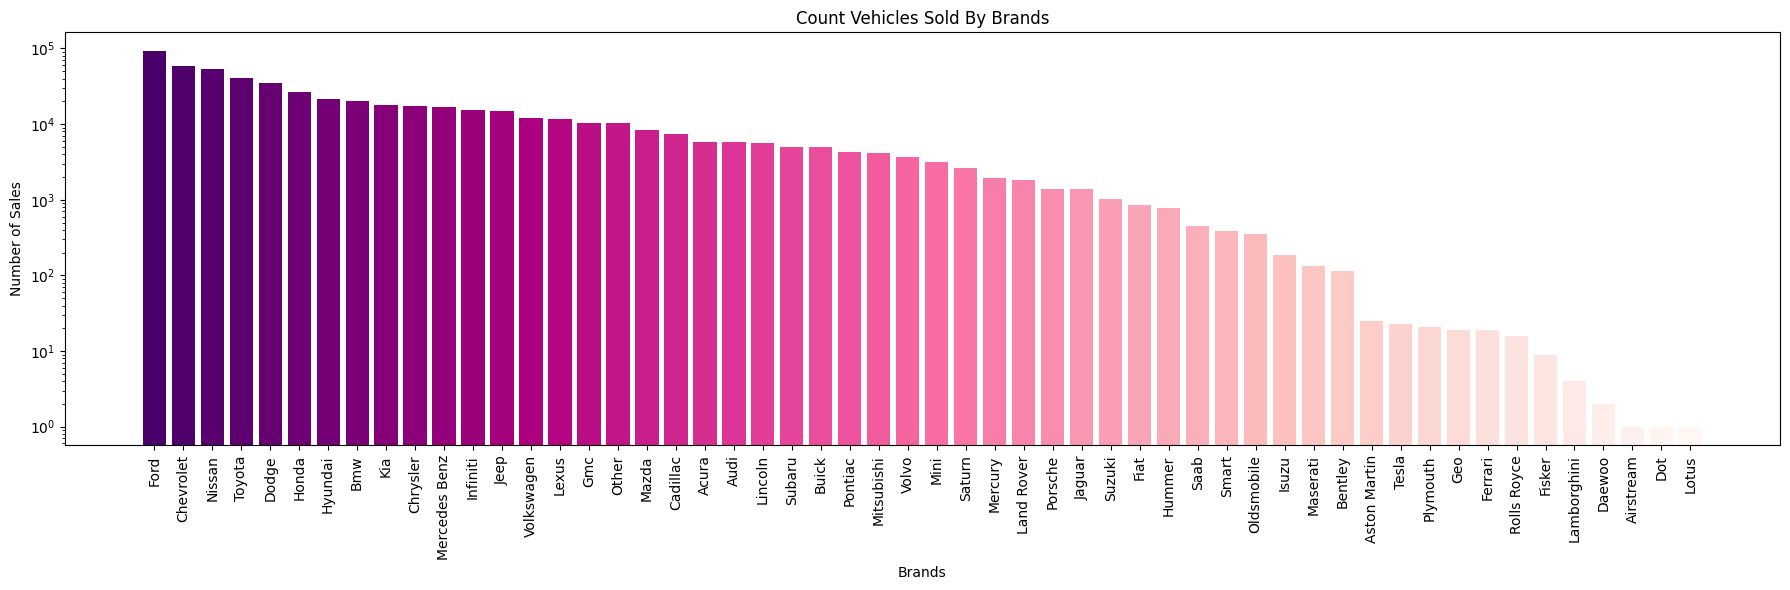

In [10]:
count_plot(df['make'], 'Brands', 90)

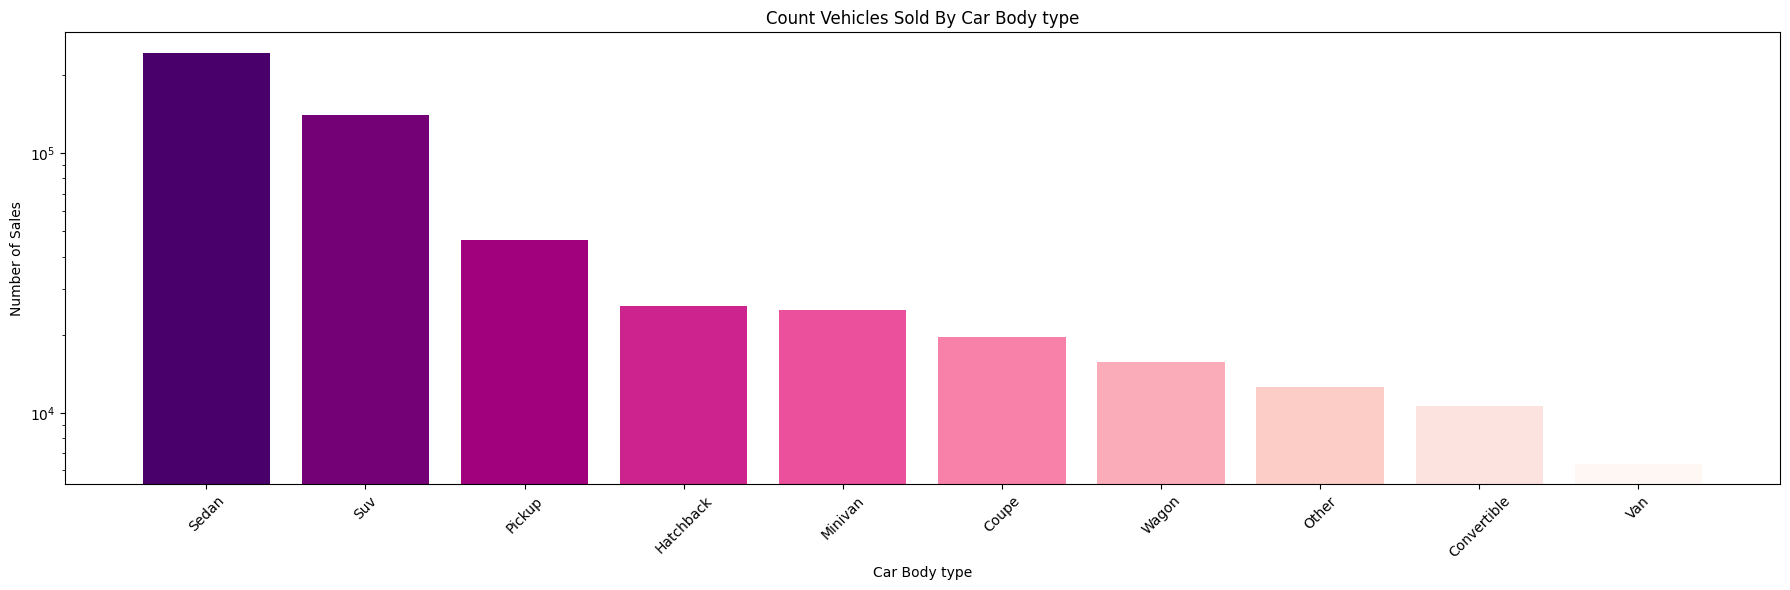

In [11]:
count_plot(df['body'], 'Car Body type', 45)

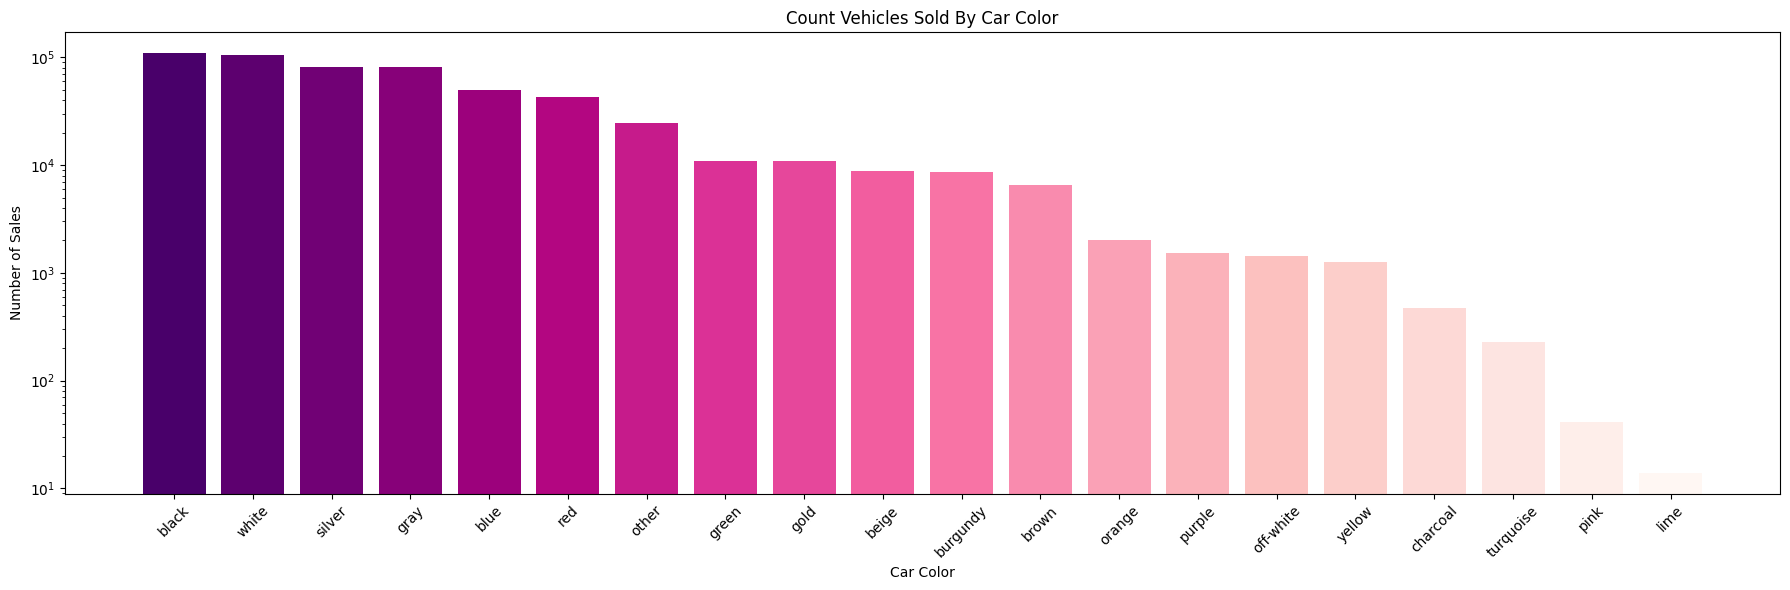

In [12]:
count_plot(df['color'], 'Car Color', 45)

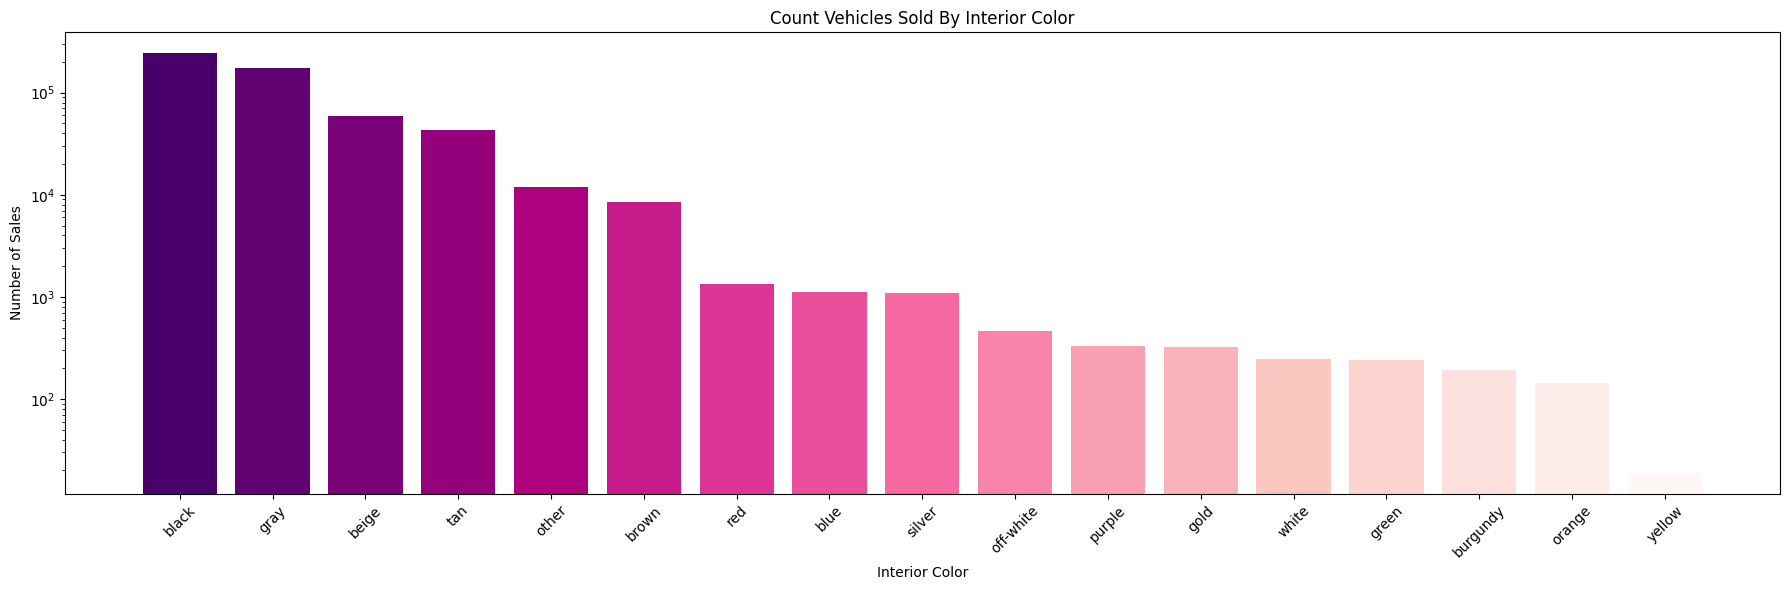

In [13]:
count_plot(df['interior'], 'Interior Color', 45)

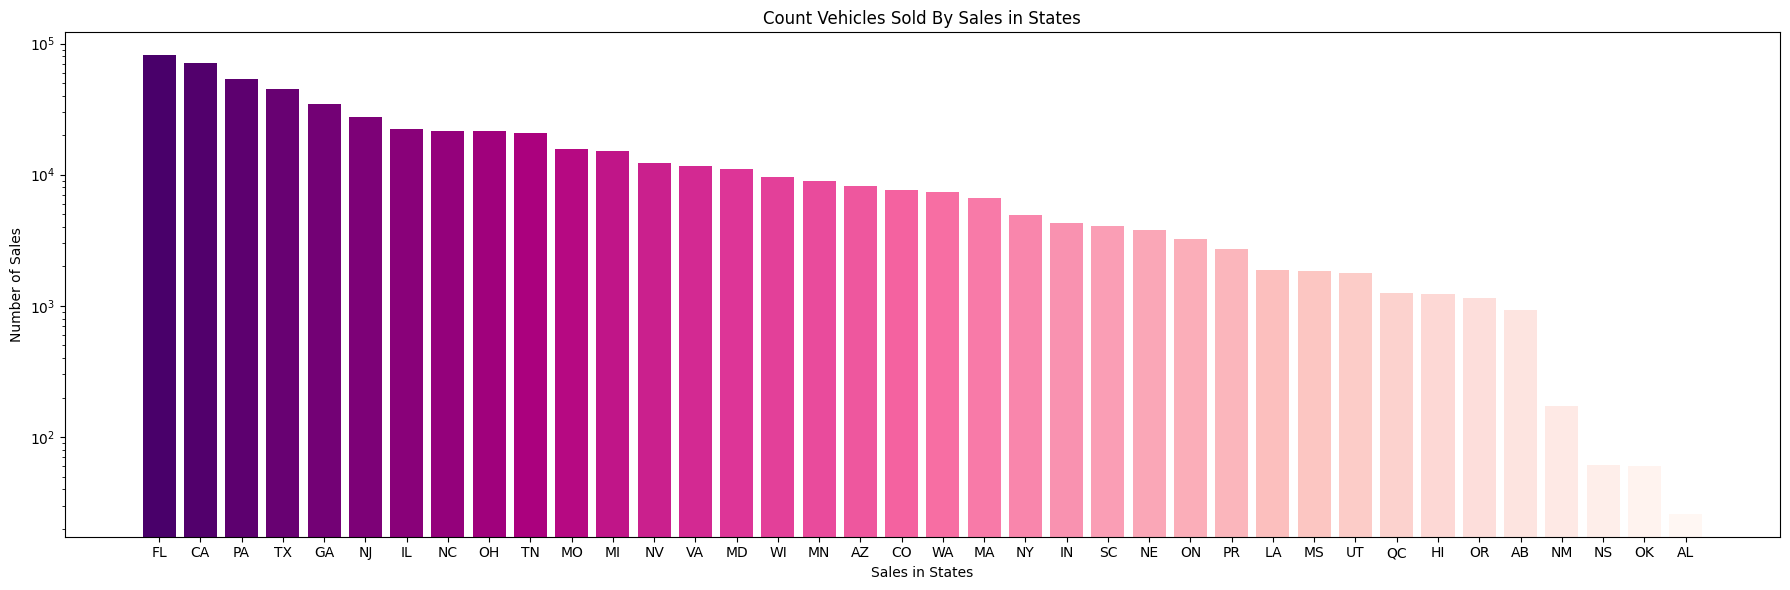

In [14]:
df['state'] = df['state'].str.upper()
count_plot(df['state'], 'Sales in States', 0)

In [15]:
def dot_plot(col1, col2, label1, label2, xscale='linear', yscale='linear', size = (15,5)):
    plt.figure(figsize=size)
    plt.xscale(xscale)
    plt.yscale(yscale)
    plt.scatter(col1.values, col2.values, s=1)
    plt.title(f'{label1} VS {label2}', fontsize=16)
    plt.xlabel(label1, fontsize=14)
    plt.ylabel(label2, fontsize=14)
    plt.tight_layout()
    plt.show()

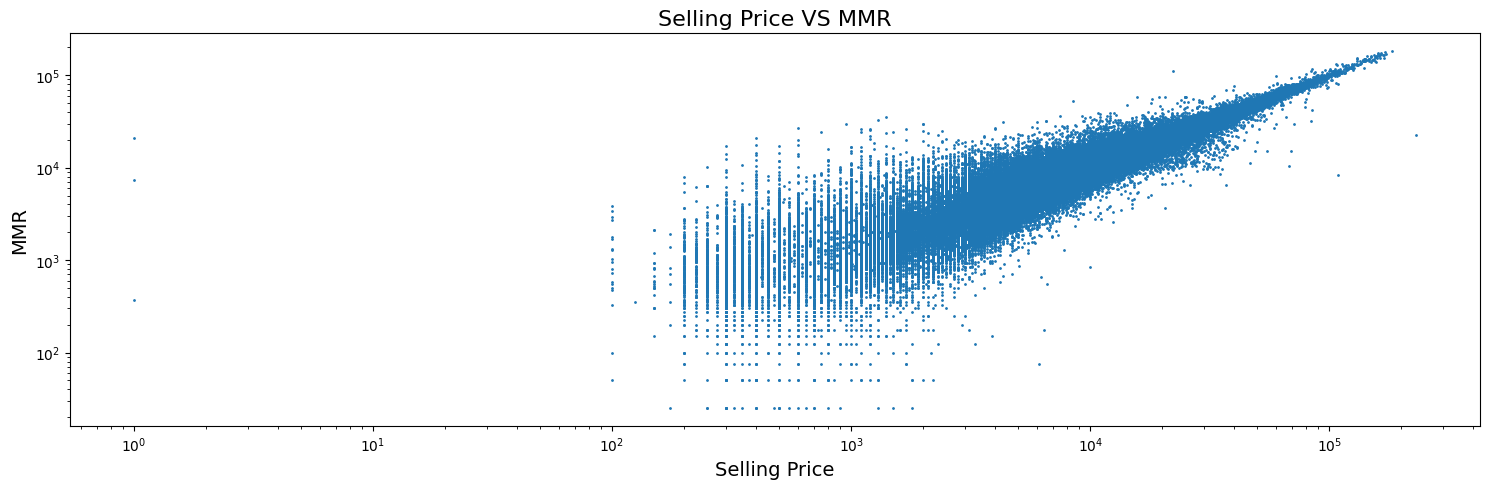

In [16]:
dot_plot(df['sellingprice'], df['mmr'], 'Selling Price', 'MMR', 'log', 'log')

df.groupby('make')[['sellingprice', 'newcondition']].mean().sort_values(by=['sellingprice', 'newcondition'], ascending=False)

df.groupby('make')[['sellingprice']].sum().sort_values(by=['sellingprice'], ascending=False)

df.groupby('state')[['sellingprice', 'newcondition']].mean().sort_values(by=['sellingprice', 'newcondition'], ascending=False)

df.groupby('year')[['sellingprice', 'newcondition']].mean().sort_values(by=['sellingprice', 'newcondition'], ascending=False)

['year' 'condition' 'odometer' 'sellingprice' 'newcondition' 'carage'
 'saleday' 'profit']


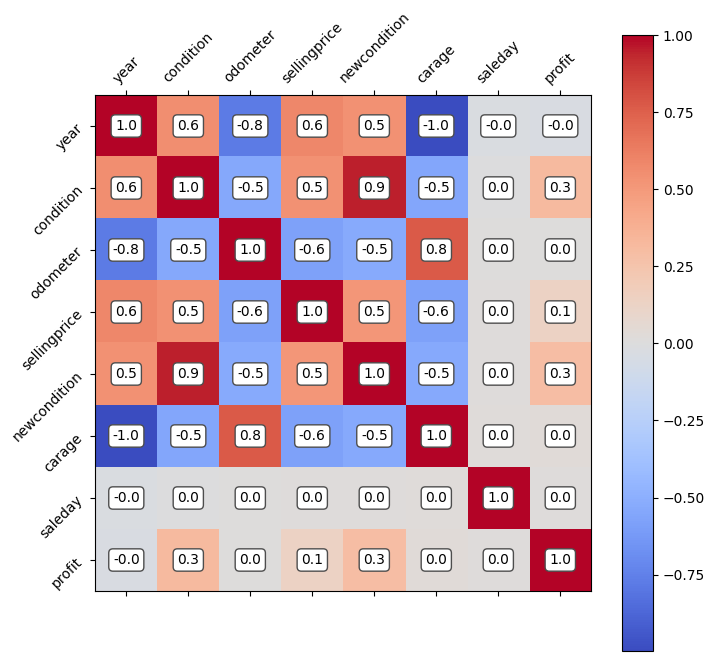

In [17]:
numerical_columns = df.select_dtypes(include=['float64', 'int64', 'int32'])
numerical_columns = numerical_columns.drop(['mmr'], axis=1)
col_list = numerical_columns.columns.values
print(col_list)
corr = numerical_columns.corr()

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
cax = ax.matshow(corr, cmap = 'coolwarm', interpolation = 'nearest')
fig.colorbar(cax)

xaxis = np.arange(len(col_list))
ax.set_xticks(xaxis)
ax.set_yticks(xaxis)
ax.set_xticklabels(col_list, rotation=45)
ax.set_yticklabels(col_list, rotation=45)
for (i, j), z in np.ndenumerate(corr):
    ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center',
            bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'))

plt.show()

In [18]:
df.info()
print('-----------------------------------')
df.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 546325 entries, 0 to 558836
Data columns (total 20 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          546325 non-null  int64  
 1   make          546325 non-null  object 
 2   model         546325 non-null  object 
 3   trim          546325 non-null  object 
 4   body          546325 non-null  object 
 5   transmission  546325 non-null  object 
 6   vin           546325 non-null  object 
 7   state         546325 non-null  object 
 8   condition     546325 non-null  float64
 9   odometer      546325 non-null  float64
 10  color         546325 non-null  object 
 11  interior      546325 non-null  object 
 12  seller        546325 non-null  object 
 13  mmr           546325 non-null  float64
 14  sellingprice  546325 non-null  float64
 15  saledate      546325 non-null  object 
 16  newcondition  546325 non-null  float64
 17  carage        546325 non-null  int32  
 18  saleday  

,year,condition,odometer,mmr,sellingprice,newcondition,carage,saleday,profit
count,546325.000000,546325.000000,546325.000000,546325.000000,546325.000000,546325.000000,546325.000000,546325.000000,546325.000000
mean,2010.132280,34.242178,67289.743418,13903.192697,13751.715761,2.920661,4.791371,1.445669,-151.476936
std,3.906608,9.493051,52781.847842,9652.965754,9724.318611,0.978638,3.902841,1.236352,1745.592613
min,1982.000000,10.000000,1.000000,25.000000,1.000000,1.000000,0.000000,0.000000,-87750.000000
25%,2008.000000,27.000000,28072.000000,7375.000000,7100.000000,2.000000,2.000000,1.000000,-800.000000
50%,2012.000000,36.000000,51260.000000,12400.000000,12300.000000,3.000000,3.000000,1.000000,-50.000000
75%,2013.000000,42.000000,97438.000000,18400.000000,18300.000000,4.000000,7.000000,2.000000,650.000000
max,2015.000000,50.000000,999999.000000,182000.000000,230000.000000,4.000000,33.000000,6.000000,207200.000000


## Insights:
1. Data set contains information on 546325 car sales in the US. The data include 6 numerical categorial and 11 verbal or object type values.
2. Oldest car sold is from 1982, suggestion older cars or classic are still in the market. Newest cars sold are from 2015.
3. Automatic transmission is by far (almost 97%) the most used transmission in the US.
4. Sedan and SUV are the most popular body types.
5. Ford, Chevrolet, Nissan, Toyota and Dodge lead the charts of vehicles sold.
6. Data contains few vehicles with very high millage, could be a intentinal by users ('999999'). On the other hand, some vehicales have very low millage, indicating sales of brand new vehicles.
7. Data contains sales in 38 states. Florida, California, Pennsylvania and Texas are the state with the highest number of vehicles sold.


After reviewing the correlation between the diffrent columns, I will drop those that does not provide any usefull infromation.

In [19]:
df = df.drop(['trim', 'vin', 'condition', 'seller', 'saledate', 'saleday', 'carage', 'mmr'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 546325 entries, 0 to 558836
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          546325 non-null  int64  
 1   make          546325 non-null  object 
 2   model         546325 non-null  object 
 3   body          546325 non-null  object 
 4   transmission  546325 non-null  object 
 5   state         546325 non-null  object 
 6   odometer      546325 non-null  float64
 7   color         546325 non-null  object 
 8   interior      546325 non-null  object 
 9   sellingprice  546325 non-null  float64
 10  newcondition  546325 non-null  float64
 11  profit        546325 non-null  float64
dtypes: float64(4), int64(1), object(7)
memory usage: 54.2+ MB


#### One-Hot Encoding

Convert low-cardinality categorical variables into a separate binary column. In our case transmission is the only low-cardinality categorical variable.

In [20]:
df = pd.get_dummies(df, columns=['transmission'], drop_first=True)

#### Label Encoding
Convert categorical variables into numerical values by assigning a unique integer to each category.
I am using label encoding becuase I will use tree-based models since they don’t assume order.

In [21]:
label_encoder_make = LabelEncoder()
label_encoder_model = LabelEncoder()
label_encoder_body = LabelEncoder()
label_encoder_state = LabelEncoder()
label_encoder_color = LabelEncoder()
label_encoder_interior = LabelEncoder()
label_encoder_saleday = LabelEncoder()
df['make'] = label_encoder_make.fit_transform(df['make'])
df['model'] = label_encoder_model.fit_transform(df['model'])
df['body'] = label_encoder_body.fit_transform(df['body'])
df['state'] = label_encoder_state.fit_transform(df['state'])
df['color'] = label_encoder_color.fit_transform(df['color'])
df['interior'] = label_encoder_interior.fit_transform(df['interior'])

Save the encoders using pickle, so later I can convert encoded values back to original labels if needed.

In [22]:
with open('make_encoder.pkl', 'wb') as make:
    pickle.dump(label_encoder_make, make)

with open('model_encoder.pkl', 'wb') as model:
    pickle.dump(label_encoder_model, model)
    
with open('body_encoder.pkl', 'wb') as body:
    pickle.dump(label_encoder_body, body)
    
with open('state_encoder.pkl', 'wb') as state:
    pickle.dump(label_encoder_state, state)
    
with open('color_encoder.pkl', 'wb') as color:
    pickle.dump(label_encoder_color, color)
    
with open('interior_encoder.pkl', 'wb') as interior:
    pickle.dump(label_encoder_interior, interior)

In [24]:
df.to_csv('car_prices_processed.csv')